# 🎯 Object Detection with OpenCV & Deep Learning

## Overview
This notebook demonstrates how to perform **object detection** using a pre-trained **SSD MobileNet V2 model** from the TensorFlow Object Detection Zoo, integrated with **OpenCV’s DNN module**.  
We walk through downloading the model, loading class labels, preparing helper functions, and finally detecting and displaying objects on a test image.

## Objectives
- Download and set up a pre-trained **SSD MobileNet V2 COCO model**.  
- Import and configure necessary libraries for object detection.  
- Load COCO class labels (80 categories).  
- Define reusable helper functions for:
  - Preprocessing input images (`detect_objects`).  
  - Displaying bounding boxes and labels (`display_text`, `display_objects`).  
- Run inference on a sample image and visualize results.  

## Key Learnings
- How to download and prepare TensorFlow object detection models (`.pb` + `.pbtxt`) for use with OpenCV.  
- Creating **blobs** with `cv2.dnn.blobFromImage()` for network input.  
- Running **forward passes** through the network to get detections.  
- Mapping detection results to **class labels** with confidence scores.  
- Drawing bounding boxes and overlaying text with **OpenCV + Matplotlib**.  

## Tools & Libraries
- **OpenCV (cv2.dnn)** → Model loading, preprocessing, object detection, visualization.  
- **NumPy** → Image array manipulation.  
- **Matplotlib** → Visualization of detection results.  
- **OS & urllib** → File handling and model download management.


# Step 1: Download Pre-trained Object Detection Model

We will use a **pre-trained model from the TensorFlow Object Detection Model Zoo**.  
The chosen model is **SSD MobileNet V2 (COCO dataset, 2018 release)**, which is fast and lightweight, suitable for real-time applications.


# Download Model files from Tensorflow model ZOO

Model files can be downloaded from the Tensorflow Object Detection Model Zoo
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

**The cell given below downloads a mobilenet model**

## Download mobilenet model file
The code below will run on Linux / MacOS systems.
Please download the file http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz

Uncompress it and put it in models folder.

**ssd_mobilenet_v2_coco_2018_03_29** <br>
|─ checkpoint <br>
|─ **frozen_inference_graph.pb** <br>
|─ model.ckpt.data-00000-of-00001 <br>
|─ model.ckpt.index <br>
|─ model.ckpt.meta <br>
|─ pipeline.config <br>
|─ saved_model <br>
|─── saved_model.pb <br>
|─── variables <br>

# Step 2: Import Required Libraries

Before we start working with object detection, we need to import the necessary Python libraries:

- **os** → for file and directory operations.  
- **cv2 (OpenCV)** → for image and video processing.  
- **numpy** → for numerical operations (arrays, matrices, image data handling).  
- **urllib** → for handling URL requests (downloading images/models if needed).  
- **matplotlib.pyplot** → for visualizing images and results.  
- **%matplotlib inline** → Jupyter magic command to display plots directly inside the notebook.


In [14]:
# -------------------------------------------
# Step 2: Import Required Libraries
# -------------------------------------------

import os               # File and directory operations
import cv2              # OpenCV for computer vision tasks
import numpy as np      # Numerical operations (arrays, matrices)
import urllib           # Handling URL requests (e.g., image download)
import matplotlib.pyplot as plt  # Plotting and visualization

# Jupyter magic to display matplotlib plots inline
%matplotlib inline


# Step 3: Prepare Model Configuration Files

To use the TensorFlow model (`frozen_inference_graph.pb`) with OpenCV’s DNN module, we need a **configuration file** (`.pbtxt`) that defines the network structure.

Steps:
1. Extract the model files (if not already extracted).
2. Use the `tf_text_graph_ssd.py` script (from OpenCV’s repo) to generate the `.pbtxt` config file.  
   - Alternatively, we can use a pre-generated sample config file provided in the `models/` folder.
3. Define the following paths:
   - **modelFile** → path to the pre-trained frozen inference graph (`.pb`).  
   - **configFile** → path to the configuration file (`.pbtxt`).  
   - **classFile** → file containing COCO dataset class labels.  

These files will allow us to load the model into OpenCV and perform object detection.


In [15]:
# -------------------------------------------
# Step 3: Prepare Model Configuration Files
# -------------------------------------------

# Paths to model and configuration files
modelFile = "models/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb"
configFile = "models/ssd_mobilenet_v2_coco_2018_03_29.pbtxt"  # Generated or pre-included config file
classFile = "data/coco_class_labels.txt"  # File containing COCO dataset class labels

# Ensure models directory exists
if not os.path.isdir("models"):
    os.mkdir("models")

# Check if frozen graph file exists, if not download and extract
if not os.path.isfile(modelFile):
    print("Model file not found. Downloading and extracting...")
    
    # Change to models directory
    os.chdir("models")
    
    # Download the pre-trained TensorFlow model
    urllib.request.urlretrieve(
        "http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz",
        "ssd_mobilenet_v2_coco_2018_03_29.tar.gz"
    )

    # Extract the tar.gz file
    !tar -xvf ssd_mobilenet_v2_coco_2018_03_29.tar.gz

    # Remove the tar.gz file after extraction
    os.remove("ssd_mobilenet_v2_coco_2018_03_29.tar.gz")

    # Change back to parent directory
    os.chdir("..")

    print("Model successfully downloaded and extracted.")
else:
    print("Model already exists. Skipping download.")


Model already exists. Skipping download.


# Step 4: Load COCO Class Labels

The COCO dataset contains **80 object categories** (e.g., person, car, dog, bicycle, etc.).  
We need to load these labels from the `coco_class_labels.txt` file so that when the model detects objects, we can map the class IDs to human-readable names.

This step:
1. Opens the `coco_class_labels.txt` file.  
2. Reads all class names line by line.  
3. Stores them in a Python list for later use in visualization.


In [16]:
# -------------------------------------------
# Step 4: Load COCO Class Labels
# -------------------------------------------

# Open the class labels file and read each line
with open(classFile, "r") as fp:
    labels = fp.read().strip().split("\n")

# Print the loaded labels to verify
print("Loaded COCO class labels:")
print(labels)
print(f"\nTotal classes: {len(labels)}")


Loaded COCO class labels:
['unlabeled', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'

# Step 5: Load TensorFlow DNN Model

The general steps for performing inference using a Deep Neural Network (DNN) in OpenCV are:

1. **Load the pre-trained model and configuration file** into memory.  
2. **Read the input image/video** that we want to process.  
3. **Run a forward pass** of the network to detect objects.  
4. **Visualize results** → draw bounding boxes and display class labels.

---

### In this step:
We will use `cv2.dnn.readNetFromTensorflow()` to load the **SSD MobileNet V2 model**:
- `modelFile` → `frozen_inference_graph.pb` (pre-trained weights).  
- `configFile` → `.pbtxt` file (network structure/configuration).  


In [17]:
# -------------------------------------------
# Step 5: Load TensorFlow DNN Model
# -------------------------------------------

# Load the pre-trained TensorFlow SSD MobileNet V2 model
# modelFile = frozen_inference_graph.pb (weights)
# configFile = pbtxt file (model configuration)
net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)

print("✅ Model successfully loaded into OpenCV DNN module.")


✅ Model successfully loaded into OpenCV DNN module.


# Step 6: Define Helper Functions for Detection & Visualization

To make our workflow cleaner, we will define two helper functions:

1. **`detect_objects(net, im)`**  
   - Converts the input image into a *blob* (preprocessed format expected by the DNN).  
   - Performs a forward pass through the network.  
   - Returns the detected objects.  

   > The input image is resized to **300x300 pixels** (as required by SSD MobileNet V2).

2. **`display_text(im, text, x, y)`**  
   - Draws a black rectangle as a background.  
   - Places the given text (e.g., class label, confidence score) above the bounding box.  

These functions will be used later to display detection results clearly on the image.


In [18]:
def detect_objects(net, im):
    """
    Perform object detection on an input image using the loaded DNN model.
    
    Args:
        net: Loaded DNN model (cv2.dnn.Net).
        im: Input image (numpy array).
        
    Returns:
        objects: Detected objects (from network forward pass).
    """
    dim = 300  # Model input size (300x300 for SSD MobileNet)

    # Create a blob from the image
    blob = cv2.dnn.blobFromImage(
        im, 1.0, size=(dim, dim), mean=(0, 0, 0), swapRB=True, crop=False
    )

    # Set the blob as input to the network
    net.setInput(blob)

    # Perform forward pass (prediction)
    objects = net.forward()
    return objects


In [19]:
def display_text(im, text, x, y):
    """
    Display text with background rectangle on an image.
    
    Args:
        im: Input image (numpy array).
        text: String to display.
        x, y: Coordinates for text placement.
    """
    # Get text size and baseline
    textSize, baseline = cv2.getTextSize(text, FONTFACE, FONT_SCALE, THICKNESS)
    dim = textSize

    # Draw filled black rectangle as text background
    cv2.rectangle(
        im, 
        (x, y - dim[1] - baseline), 
        (x + dim[0], y + baseline), 
        (0, 0, 0), 
        cv2.FILLED
    )

    # Put yellow text on top of the black rectangle
    cv2.putText(
        im, text, (x, y - 5), FONTFACE, FONT_SCALE, (0, 255, 255), THICKNESS, cv2.LINE_AA
    )


# Step 7: Display Detected Objects

Now we define a function to visualize detections on an image:

- **Set font parameters** for labels:
  - `FONTFACE` → type of font (OpenCV built-in).  
  - `FONT_SCALE` → size of the text.  
  - `THICKNESS` → thickness of the text.  

- **`display_objects(im, objects, threshold=0.25)`**:
  1. Iterates through all detections returned by the network.  
  2. Extracts:
     - `classId` → detected class index.  
     - `score` → confidence of detection.  
     - Bounding box coordinates (x, y, width, height).  
  3. If confidence is above `threshold` (default = 0.25):
     - Draws a bounding box around the object.  
     - Displays the class label using `display_text()`.  
  4. Converts the image from **BGR (OpenCV)** to **RGB (Matplotlib)** for correct display.  


In [20]:
# -------------------------------------------
# Step 7: Display Detected Objects
# -------------------------------------------

# Font parameters for displaying labels
FONTFACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
THICKNESS = 1

def display_objects(im, objects, threshold=0.25):
    """
    Display detected objects with bounding boxes and class labels on the image.
    
    Args:
        im: Input image (numpy array).
        objects: Detected objects (from DNN forward pass).
        threshold: Confidence threshold (default=0.25).
    """
    rows, cols = im.shape[0], im.shape[1]

    # Loop through all detections
    for i in range(objects.shape[2]):
        # Extract class ID and confidence score
        classId = int(objects[0, 0, i, 1])
        score = float(objects[0, 0, i, 2])

        # Convert normalized coordinates back to original image size
        x = int(objects[0, 0, i, 3] * cols)
        y = int(objects[0, 0, i, 4] * rows)
        w = int(objects[0, 0, i, 5] * cols - x)
        h = int(objects[0, 0, i, 6] * rows - y)

        # Draw bounding box and label if detection is above threshold
        if score > threshold:
            label_text = "{}: {:.2f}".format(labels[classId], score)
            display_text(im, label_text, x, y)
            cv2.rectangle(im, (x, y), (x + w, y + h), (255, 255, 255), 2)

    # Convert BGR (OpenCV format) to RGB (Matplotlib format) for correct display
    mp_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(30, 10))
    plt.imshow(mp_img)
    plt.axis("off")
    plt.show()


# Step 8: Run Object Detection on a Test Image

Finally, let’s test the entire pipeline:

1. Load a sample image (here: `data/street.jpg`).  
2. Perform object detection using the **SSD MobileNet V2 model**.  
3. Display the results with bounding boxes and class labels.  


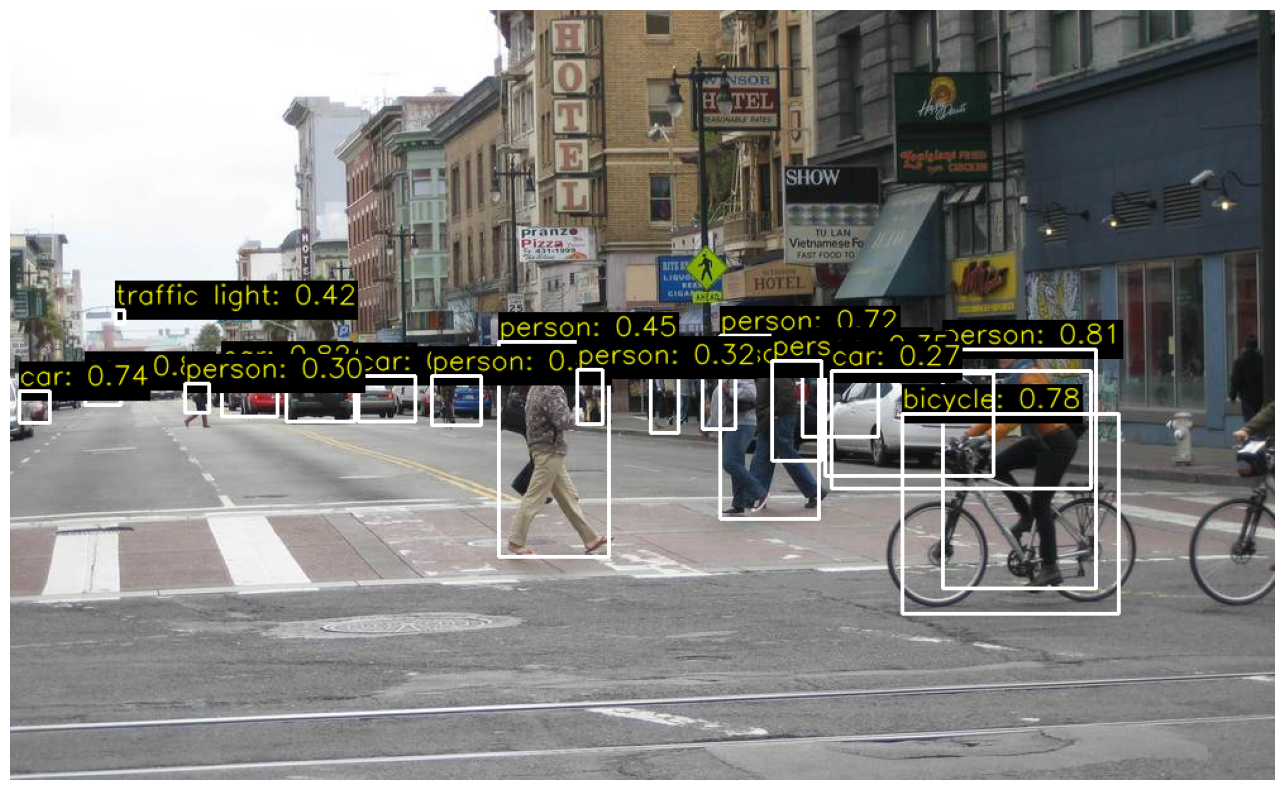

In [26]:
# -------------------------------------------
# Step 8: Run Object Detection on a Test Image
# -------------------------------------------

# Read input image
im = cv2.imread("data/street.jpg")

# Perform detection
objects = detect_objects(net, im)

# Display detections with bounding boxes and labels
display_objects(im, objects)


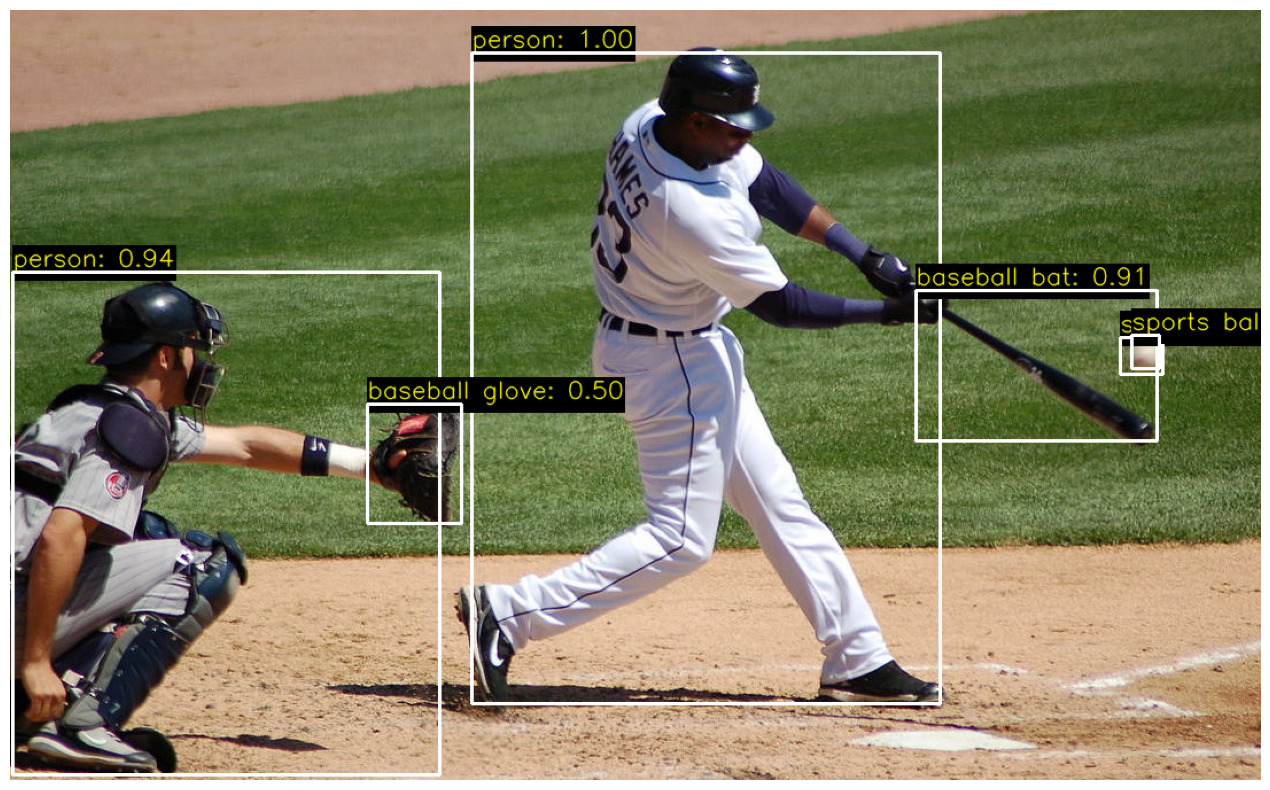

In [25]:
im = cv2.imread('data/baseball.jpg')
objects = detect_objects(net, im)
display_objects(im, objects, 0.2)

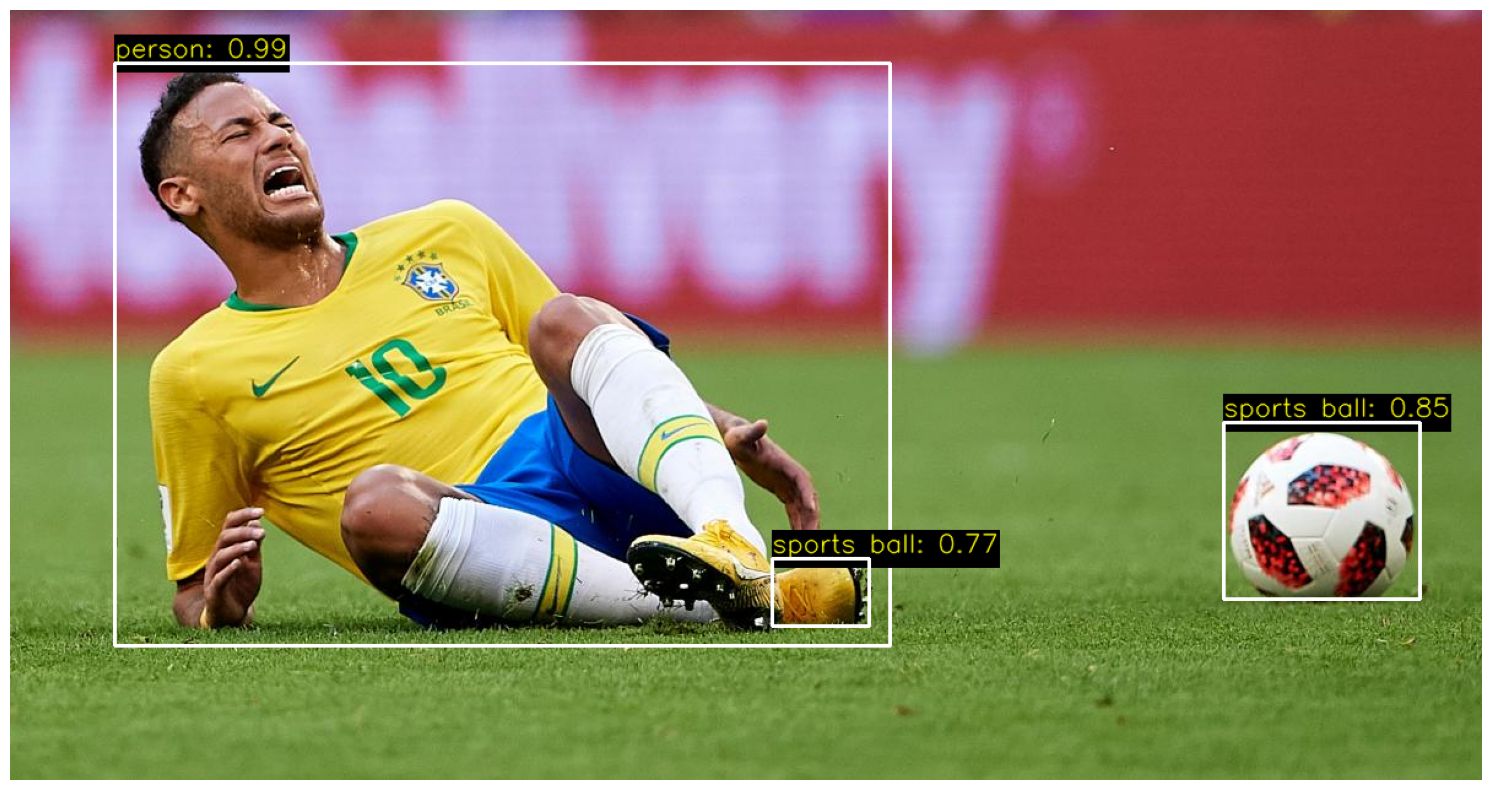

In [24]:
im = cv2.imread('data/soccer.jpg')
objects = detect_objects(net, im)
display_objects(im, objects)